# 制御シミュレーション

In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
using MatrixEquations

## 振り子のモデル

In [2]:
const M = 1
const m = 0.7
const l = 0.15
const D_x = 0.01
const D_θ = 0.01
const g = 9.80665

function fxu!(dx::Vector{T}, x::Vector{T}, u::T) where T
    dx[1] = x[2]
    dx[2] = (3*D_θ*cos(x[3])*x[4]/(4*M*l + 3*l*m*sin(x[3])^2 + l*m)
    - 4*D_x*l*x[2]/(4*M*l + 3*l*m*sin(x[3])^2 + l*m)
    - 3*g*l*m*sin(2*x[3])/(8*M*l + 6*l*m*sin(x[3])^2 + 2*l*m)
    + 4*l^2*m*sin(x[3])*x[4]^2/(4*M*l + 3*l*m*sin(x[3])^2 + l*m)
    + 4*l*u/(4*M*l + 3*l*m*sin(x[3])^2 + l*m))
    dx[3] = x[4]
    dx[4] = (-3*D_θ*M*x[4]/(4*M*l^2*m + 3*l^2*m^2*sin(x[3])^2 + l^2*m^2)
    - 3*D_θ*m*x[4]/(4*M*l^2*m + 3*l^2*m^2*sin(x[3])^2 + l^2*m^2)
    + 3*D_x*l*m*cos(x[3])*x[2]/(4*M*l^2*m + 3*l^2*m^2*sin(x[3])^2 + l^2*m^2)
    + 3*M*g*l*m*sin(x[3])/(4*M*l^2*m + 3*l^2*m^2*sin(x[3])^2 + l^2*m^2)
    + 3*g*l*m^2*sin(x[3])/(4*M*l^2*m + 3*l^2*m^2*sin(x[3])^2 + l^2*m^2)
    - 3*l^2*m^2*sin(2*x[3])*x[4]^2/(8*M*l^2*m + 6*l^2*m^2*sin(x[3])^2 + 2*l^2*m^2)
    - 3*l*m*u*cos(x[3])/(4*M*l^2*m + 3*l^2*m^2*sin(x[3])^2 + l^2*m^2))
end

fxu! (generic function with 1 method)

In [4]:

function A(x::Vector{T}) where T
    out = Matrix{T}(undef, 4, 4)
    out[1,1] = 0
    out[1,2] = 1
    out[1,3] = 0
    out[1,4] = 0
    out[2,1] = 0
    out[2,2] = -4*D_x/(4*M + 3*m*sin(x[3])^2 + m)
    out[2,3] = (-6*m*(3*D_θ*cos(x[3])*x[4] - 4*D_x*l*x[2] - 3*g*l*m*sin(2*x[3])/2
    + 4*l^2*m*sin(x[3])*x[4]^2)*sin(x[3])*cos(x[3])/(l*(4*M
    + 3*m*sin(x[3])^2 + m)^2) + (-3*D_θ*sin(x[3])*x[4] - 3*g*l*m*cos(2*x[3])
    + 4*l^2*m*cos(x[3])*x[4]^2)/(l*(4*M + 3*m*sin(x[3])^2 + m)))
    out[2,4] = (3*D_θ*cos(x[3]) + 8*l^2*m*sin(x[3])*x[4])/(l*(4*M + 3*m*sin(x[3])^2 + m))
    out[3,1] = 0
    out[3,2] = 0
    out[3,3] = 0
    out[3,4] = 1
    out[4,1] = 0
    out[4,2] = 3*D_x*cos(x[3])/(l*(4*M + 3*m*sin(x[3])^2 + m))
    out[4,3] = (-18*(-D_θ*M*x[4] - D_θ*m*x[4] + D_x*l*m*cos(x[3])*x[2] + M*g*l*m*sin(x[3])
    + g*l*m^2*sin(x[3]) - l^2*m^2*sin(2*x[3])*x[4]^2/2)*sin(x[3])*cos(x[3])/(l^2*(4*M + 3*m*sin(x[3])^2 + m)^2)
    + 3*(-D_x*l*m*sin(x[3])*x[2] + M*g*l*m*cos(x[3]) + g*l*m^2*cos(x[3])
    - l^2*m^2*cos(2*x[3])*x[4]^2)/(l^2*m*(4*M + 3*m*sin(x[3])^2 + m)))
    out[4,4] = 3*(-D_θ*M - D_θ*m - l^2*m^2*sin(2*x[3])*x[4])/(l^2*m*(4*M + 3*m*sin(x[3])^2 + m))
    out
end

function B(x::Vector{T}) where T
    out = Vector{T}(undef, 4)
    out[1] = 0
    out[2] = 4*l/(4*M*l + 3*l*m*(sin(x[3])^2) + l*m)
    out[3] = 0
    out[4] = -3*l*m*cos(x[3])/(4*M*l^2*m + 3*l^2*m^2*(sin(x[3])^2) + l^2*m^2)
    out
end

B (generic function with 1 method)

# 制御則
## PID

In [5]:
mutable struct PID{T}
    Kp::T
    Ki::T
    Kd::T
    error::T
end

function input(p::PID{T}, x::Vector{T}) where T
    p.Kp*(x[3]) + p.Kd*(x[4]) + p.Ki*(p.error)
end

function dx!(dx::Vector{T}, x::Vector{T}, p::PID{T}, t::T) where T
    p.error = p.error + x[3]*0.01
    fxu!(dx, x, input(p, x))
end

function run_simuration(p::PID{T}, t_span::Tuple{T, T}, x₀::Vector{T}) where T
    prob = ODEProblem(dx!, x₀, t_span, p)
    sol = solve(prob)
    sol
end

run_simuration (generic function with 1 method)

## LQR

In [60]:
mutable struct LQR{T}
    Q::Matrix{T}
    R::Matrix{T}
    F::Matrix{T}
end

function init!(p::LQR{T}, A::Matrix{T}, B::Vector{T}) where T
    S = zero(B)
    P, _, _ = arec(A, B, p.R, p.Q, S)
    p.F = inv(p.R) * B' * P
end

function input(p::LQR{T}, x::Vector{T}) where T
    -(p.F * x)[1,1]
end

function dx!(dx::Vector{T}, x::Vector{T}, p::LQR{T}, t::T) where T
    fxu!(dx, x, input(p, x))
end

function run_simuration(p::LQR{T}, t_span::Tuple{T, T}, x₀::Vector{T}) where T
    init!(p, A(zeros(T, 4)), B(zeros(T, 4)))
    prob = ODEProblem(dx!, x₀, t_span, p)
    sol = solve(prob)
    sol
end

run_simuration (generic function with 4 methods)

# シミュレーション

In [6]:
function make_animation(sol,name)
    ani = @animate for t in 0:0.01:5
        now = round(t, digits=2)
        s = "t = " * string(now) * " [s]"
        x, _, θ, _ = sol(t)
        plot([x, x+2l*cos(π/2-θ)], [0, 2l*sin(π/2-θ)], label="pen")
        plot!(xlim=(-5l,5l), ylim=(-2l, 2l), aspect_ratio = 1, annotate=(0, -l, s))
    end
    gif(ani, name*".gif")
end

make_animation (generic function with 1 method)

In [62]:
x₀ = [0, 0, π/6, 0]
p = LQR(diagm([10.0, 0, 100, 0]), Matrix{Float64}(I, 1, 1).*0.01, Matrix{Float64}(undef, 4, 4))
@time sol = run_simuration(p, (0.0, 5.0), x₀);

  1.404506 seconds (1.97 M allocations: 111.843 MiB, 99.96% compilation time)


In [63]:
plot(sol, label=["x" "v" "θ" "ω"], title="LQR")
savefig("lqr.png")

![lqr](lqr.png)

┌ Info: Saved animation to 
│   fn = c:\Users\Yoshi\source_control_study\ans_2022\excercise\julia_src\lqr.gif
└ @ Plots C:\Users\Yoshi\.julia\packages\Plots\Awg62\src\animation.jl:104


Plots.AnimatedGif("c:\\Users\\Yoshi\\source_control_study\\ans_2022\\excercise\\julia_src\\lqr.gif")
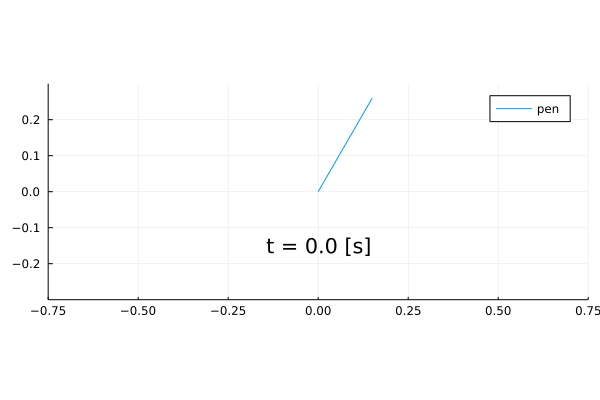

In [64]:
make_animation(sol, "lqr")

In [18]:
x₀ = [0, 0, π/6, 0]
p2 = PID(150., 5., 15., 0.)
@time sol2 = run_simuration(p2, (0.0, 5.0), x₀);

  0.001525 seconds (11.79 k allocations: 1.384 MiB)


In [19]:
plot(sol2, label=["x" "v" "θ" "ω"], title="PID")
savefig("pid.png")

![pid](pid.png)

┌ Info: Saved animation to 
│   fn = c:\Users\Yoshi\source_control_study\ans_2022\excercise\julia_src\pid.gif
└ @ Plots C:\Users\Yoshi\.julia\packages\Plots\Awg62\src\animation.jl:104


Plots.AnimatedGif("c:\\Users\\Yoshi\\source_control_study\\ans_2022\\excercise\\julia_src\\pid.gif")
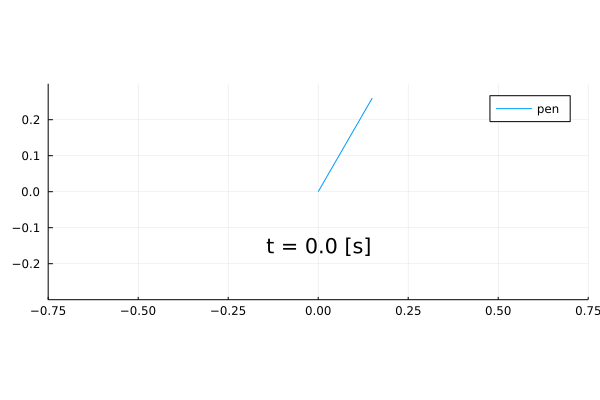

In [20]:
make_animation(sol2, "pid")